# 주피터 분석 사례 - multi-omics 딥러닝 예측 모델 연구

> * **헬스케어 빅데이터 쇼케이스 사례 분석 08**
> * 작성: (주)인실리코젠 DSC 권영인 (dsc@insilicogen.com)
> * 문서버전: v0.1 (2023-05-24)

본 문서는 Liquid Biopsy, RNA-seq, Methyl-seq 세 종류의 멀티 오믹스 데이터를 입력으로 하여 임상적 특성을 예측하는 멀티오믹스 딥러닝 모델 연구 사례를 제공합니다.

다중오믹스(Multi-omics) 분석은 유전체(Genome), 전사체(Transcriptome), 단백체(Proteome), 대사체(Metabolome), 후성유전체(Epigenome), 지질체(Lipodome) 등 다양한 분자 수준에서 생성된 여러 데이터들의 총체적이고 통합적인 분석을 의미합니다. 생명 현상은 하나의 원인이 아니라 다양한 선천/후천적인 요인이 긴밀하게 관여하여 결정되므로, 단일 분석뿐만 아니라 다중오믹스 접근 방식이 각광받고 있습니다. 하지만 다중오믹스 분석은 데이터의 규모가 크고, 필요한 지식의 양이 방대하여 연구의 난이도가 높은 편입니다.

개인의 건강을 결정하는 요인 (출처: determinantsofhealth.org)
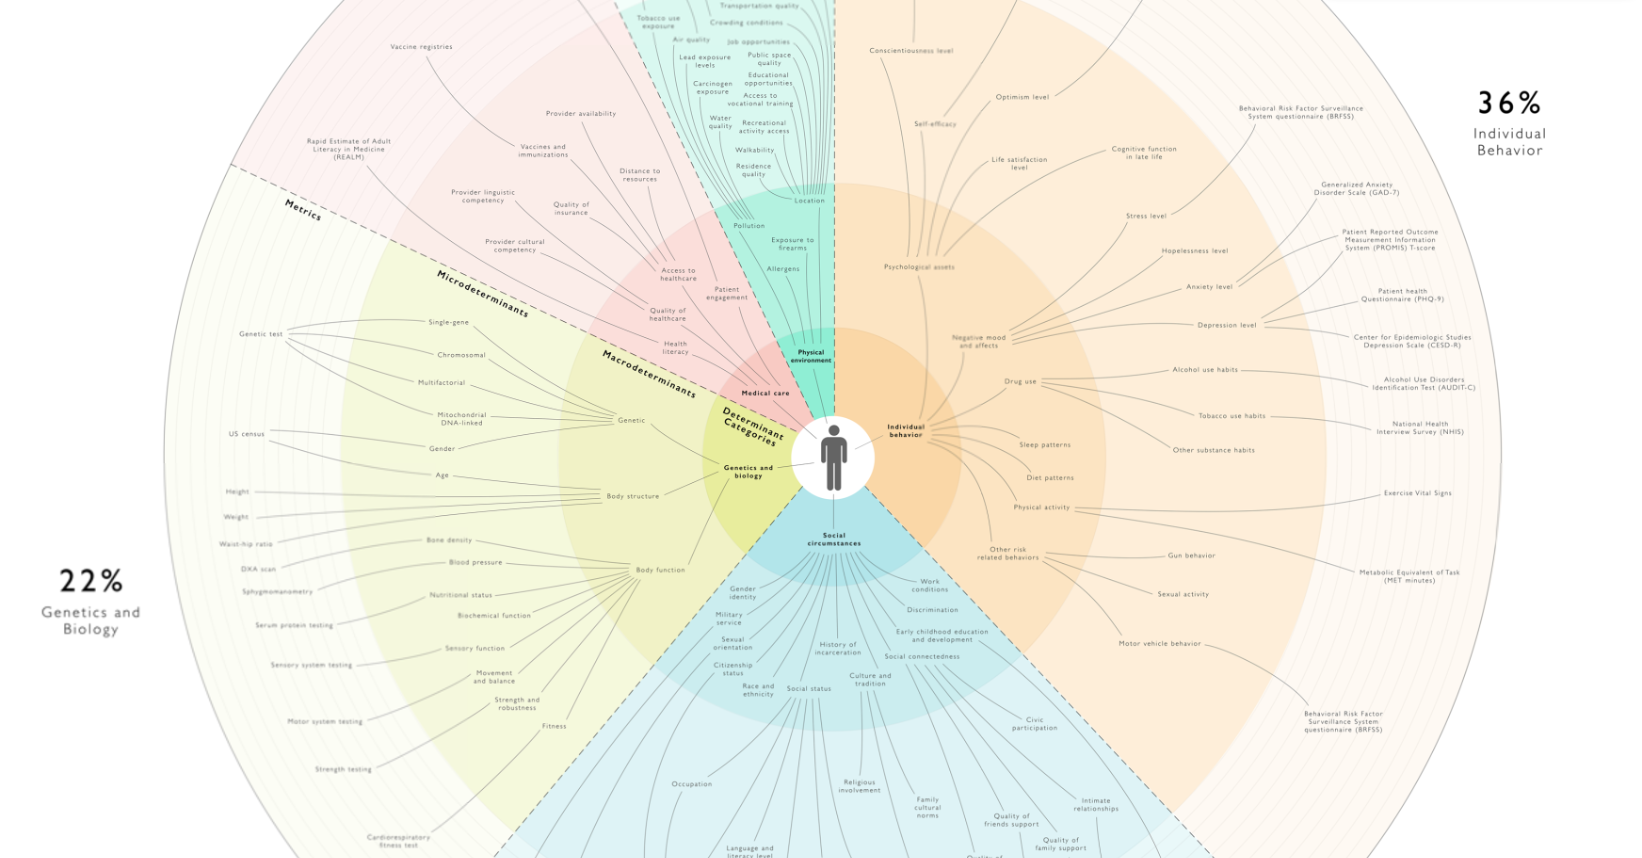

헬스케어 빅데이터 쇼케이스에서 구축한 오믹스 데이터는 약 1000명의 대상자에 대한 Liquid Biopsy, RNA-seq, Methyl-seq 등 다양한 종류의 오믹스 데이터를 포함합니다. 이중 다수의 샘플을 확보하여 연구에 활용하기 위하여 유전체, 전사체, 후성유전체 기반의 멀티오믹스 연구를 수행하였습니다. 멀티오믹스 접근 방식으로는 딥러닝(deep learning) 기술을 채택하였습니다. 딥러닝 기술은 여러 비선형적인 변환기법을 조합하여 높은 수준의 추상화를 시도하는 기계학습(machine learning)알고리즘의 집합으로 인공지능의 하위개념입니다. 본 연구는 여러 층을 가진 인공신경망(Artificial Intelligence Network)에 기반하여 다중오믹스를 통한 임상적 특성을 예측 분류하는 모형을 학습하고 평가하였으며, 이를 통해 헬스케어 빅데이터의 멀티오믹스 분석 가능성을 확인하였습니다.

딥러닝 예시 (출처: IBM)
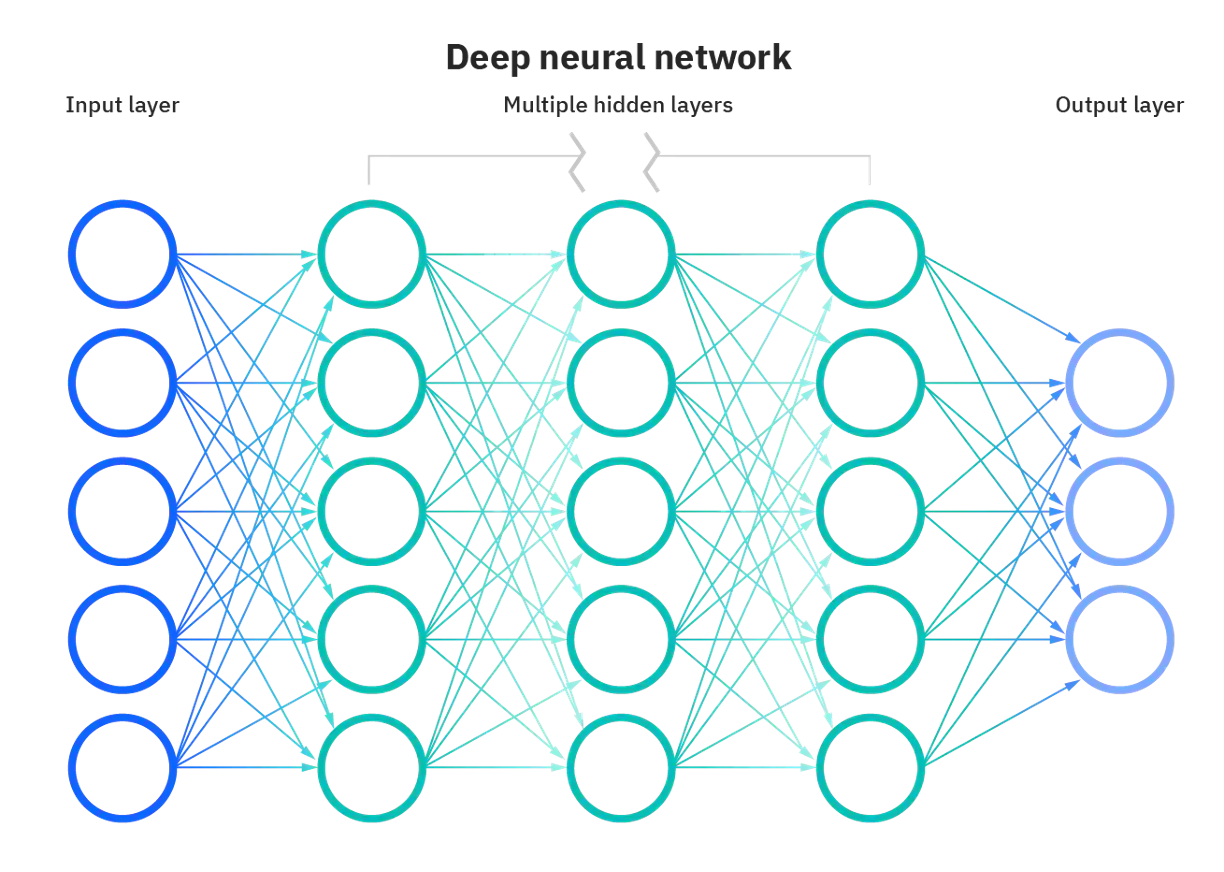

딥러닝 기반의 다중오믹스 예측 모형 연구의 흐름은 다음과 같습니다.
1. 라이브러리 로드
1. 데이터 준비
   1. Liquid Biopsy
   1. RNA-seq
   1. Methyl-seq
   1. 임상 정보
1. 데이터 병합
1. Autoencoder 기반 차원 축소
   1. Liquid Biopsy
   1. RNA-seq
   1. Methyl-seq
   1. 차원 축소 결과 확인
1. 분류 모델 학습 및 평가
   1. 모델 학습
   1. 모델 평가

(※ 이 문서는 다른 연구의 토대를 마련하기 위한 목적으로 작성하였으므로 실제 연구에 활용하기 위해서는 모델 구조의 고도화 및 최적화가 필요합니다.)

## 필요한 라이브러리 로드

본 분석에 필요한 파이썬 라이브러리를 다음처럼 로드합니다.

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 데이터 준비

각 오믹스 데이터가 같은 오믹스를 공유하도록 전처리하여 준비합니다. 오믹스 데이터의 대략적인 형식은 다음과 같습니다.

 * Liquid Biopsy: 인덱스-SAMPLE_ID, 컬럼-mut_type
 * RNA-seq: 인덱스-SAMPLE_ID, 컬럼-ensemble id
 * Methyl-seq: 인덱스-SAMPLE_ID, 컬럼-cpg positions
 * 임상 정보: 인덱스-SAMPLE_ID, 컬럼-임상 정보

In [2]:
DATA_PATH = 'data'

### Liquid Biopsy

`result_mut.csv` 파일에는 유전변이의 종류별 카운팅 결과가 저장되어 있습니다. 이를 `df_type` 데이터프레임으로 만듭니다.

In [3]:
type_filename = os.path.join(DATA_PATH, 'Liquid', 'result_mut_gen.csv')

In [4]:
df_type = pd.read_csv(type_filename, index_col=0).transpose()
print(df_type.shape)
df_type.head()

(600, 150)


,C>G,C[C>G]G,C[C>G],[C>G]G,T>C,C[T>C]G,C[T>C],[T>C]G,T[T>C]A,T[T>C],...,G[T>A]T,G[T>G]G,G[T>G]A,T[T>G]C,C[C>A]A,C[T>G]T,A[T>A]G,A[T>G]A,C[T>A]A,A[T>A]A
GGG-0001,175.0,12.0,34.0,50.0,521.0,53.0,150.0,169.0,34.0,117.0,...,2.0,10.0,8.0,5.0,3.0,5.0,7.0,3.0,2.0,NaN
GGG-0002,180.0,14.0,40.0,47.0,510.0,41.0,129.0,155.0,35.0,120.0,...,3.0,14.0,5.0,10.0,2.0,5.0,8.0,8.0,3.0,1.0
GGG-0003,173.0,17.0,43.0,45.0,514.0,45.0,142.0,162.0,36.0,117.0,...,2.0,9.0,9.0,7.0,1.0,7.0,10.0,6.0,4.0,NaN
GGG-0005,187.0,7.0,39.0,43.0,523.0,54.0,156.0,165.0,32.0,110.0,...,2.0,11.0,8.0,6.0,3.0,3.0,11.0,9.0,3.0,1.0
GGG-0006,177.0,10.0,34.0,46.0,525.0,47.0,151.0,168.0,34.0,126.0,...,3.0,13.0,7.0,9.0,4.0,9.0,8.0,5.0,3.0,1.0


위 자료 가운데 `N`을 제거합니다.

In [5]:
cols = [x for x in df_type.columns if 'N' not in x]
df_type = df_type[cols]
df_type.head()

,C>G,C[C>G]G,C[C>G],[C>G]G,T>C,C[T>C]G,C[T>C],[T>C]G,T[T>C]A,T[T>C],...,G[T>A]T,G[T>G]G,G[T>G]A,T[T>G]C,C[C>A]A,C[T>G]T,A[T>A]G,A[T>G]A,C[T>A]A,A[T>A]A
GGG-0001,175.0,12.0,34.0,50.0,521.0,53.0,150.0,169.0,34.0,117.0,...,2.0,10.0,8.0,5.0,3.0,5.0,7.0,3.0,2.0,NaN
GGG-0002,180.0,14.0,40.0,47.0,510.0,41.0,129.0,155.0,35.0,120.0,...,3.0,14.0,5.0,10.0,2.0,5.0,8.0,8.0,3.0,1.0
GGG-0003,173.0,17.0,43.0,45.0,514.0,45.0,142.0,162.0,36.0,117.0,...,2.0,9.0,9.0,7.0,1.0,7.0,10.0,6.0,4.0,NaN
GGG-0005,187.0,7.0,39.0,43.0,523.0,54.0,156.0,165.0,32.0,110.0,...,2.0,11.0,8.0,6.0,3.0,3.0,11.0,9.0,3.0,1.0
GGG-0006,177.0,10.0,34.0,46.0,525.0,47.0,151.0,168.0,34.0,126.0,...,3.0,13.0,7.0,9.0,4.0,9.0,8.0,5.0,3.0,1.0


위 행렬에서 볼 수 있듯이 변이 타입은 3가지가 있습니다.
 * single: C>A, T>C,... 등 단일 염기 변이
 * double: A[C>A],.... 앞에 염기가 하나 있을 때의 단일염기변이
 * triple: A[C>A]C,... 앞 뒤로 염기가 하나씩 있을 때의 단일염기변이

#### Liquid Biopsy scaling

Liquid Biopsy  데이터는 mutation type에 대한 개수를 나타낸 데이터로, 학습을 위해서는 샘플별 정규화를 수행해야 합니다.

In [6]:
from sklearn.preprocessing import scale
type_array = scale(df_type, axis=0)

In [7]:
type_array.shape

(600, 150)

In [8]:
type_array[:,0].mean(), type_array[:,0].std()

(-9.473903143468002e-16, 1.0)

In [9]:
df_liquid = pd.DataFrame(type_array, columns=df_type.columns, index=df_type.index)
df_liquid

,C>G,C[C>G]G,C[C>G],[C>G]G,T>C,C[T>C]G,C[T>C],[T>C]G,T[T>C]A,T[T>C],...,G[T>A]T,G[T>G]G,G[T>G]A,T[T>G]C,C[C>A]A,C[T>G]T,A[T>A]G,A[T>G]A,C[T>A]A,A[T>A]A
GGG-0001,0.167778,0.572886,-0.202459,0.979088,0.278607,0.551523,0.872449,0.146939,-0.388435,-0.193196,...,0.037617,-0.939246,0.666221,-1.013557,0.744800,-0.459210,-1.263353,-1.532208,-0.633714,NaN
GGG-0002,0.554365,1.286023,0.911996,0.443742,-0.090261,-1.552856,-0.951789,-1.003374,-0.140761,0.133333,...,1.212095,0.483854,-0.883130,1.458533,-0.173843,-0.459210,-0.646080,1.014398,0.277250,-0.934525
GGG-0003,0.013144,2.355728,1.469224,0.086845,0.043873,-0.851397,0.177501,-0.428218,0.106912,-0.193196,...,0.037617,-1.295021,1.182672,-0.024721,-1.092486,0.798900,0.588467,-0.004244,1.188213,NaN
GGG-0005,1.095586,-1.209955,0.726254,-0.270052,0.345673,0.726888,1.393660,-0.181722,-0.883782,-0.955097,...,0.037617,-0.583471,0.666221,-0.519139,0.744800,-1.717321,1.205741,1.523719,0.277250,-0.934525
GGG-0006,0.322413,-0.140250,-0.202459,0.265294,0.412740,-0.500667,0.959318,0.064774,-0.388435,0.786390,...,1.212095,0.128079,0.149771,0.964115,1.663443,2.057011,-0.646080,-0.513566,0.277250,-0.934525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BBB-0110,-1.997105,-1.209955,-1.316915,-1.519193,-1.465130,-0.149937,-1.559869,-1.332035,-0.140761,-0.846254,...,0.037617,-0.227696,-1.916032,-0.024721,0.744800,-0.459210,0.588467,-0.004244,1.188213,NaN
BBB-0126,-1.610519,-1.566523,-0.573945,-1.340744,-1.062729,-1.552856,-1.125526,-1.167705,-0.140761,0.242176,...,1.212095,1.195404,2.215573,0.469697,0.744800,-1.088266,-0.028806,-0.513566,0.277250,-0.934525
BBB-0162,0.554365,-0.853387,-1.316915,0.979088,-1.062729,-1.377491,-0.778052,-0.346052,-0.883782,-0.737411,...,0.037617,0.483854,-0.366680,-1.507974,0.744800,0.798900,-1.263353,0.505077,0.277250,NaN
BBB-0199,-1.146615,0.572886,-0.945430,-1.340744,-1.096263,-1.552856,-1.646737,-1.167705,1.345280,-0.193196,...,0.037617,-0.939246,-0.883130,-0.024721,0.744800,-1.088266,-0.646080,-0.004244,-1.544677,NaN


In [10]:
df_liquid.isnull().sum().sum()

240

#### Nan 값 처리 

딥러닝의 input으로 활용하기 위해선 raw data에 Nan값이 없는것이 좋음 따라서, 데이터 내 결측치가 존재함으로 해당 데이터를 KNN imputer 사용하여 채워 넣음.

In [11]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
df_liquid = pd.DataFrame(imputer.fit_transform(df_liquid),
                         index=df_liquid.index,
                         columns=df_liquid.columns)

print(f'결측값 개수: {df_liquid.isnull().sum().sum()}')
print(f'Shape: {df_liquid.shape}')

결측값 개수: 0
Shape: (600, 150)


### RNA-seq

#### 데이터 불러오기

In [24]:
# RNA-seq tpm matrix
tpm_path = os.path.join(DATA_PATH, 'RNA', 'tpm_matrix_23-05-11.csv.gz')

In [25]:
df_rnaseq = pd.read_csv(tpm_path, index_col=0)
print(df_rnaseq.shape)
df_rnaseq.head()

(1000, 28284)


,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000288076,ENSG00000288079,ENSG00000288082,ENSG00000288086,ENSG00000288087,ENSG00000288091,ENSG00000288093,ENSG00000288101,ENSG00000288105,ENSG00000288107
NNN-0048,0.538793,2.951771,1.785372,0.988988,6.821849,1.202676,2.814033,2.373088,2.756008,0.949265,...,0.302029,0.774952,0.320031,0.235720,0.310418,0.301442,0.749682,0.640486,0.242927,0.650142
CCC-0118,0.532428,3.341632,1.852127,0.907505,6.551564,0.908718,2.258454,2.347597,2.970261,1.276443,...,0.263976,0.283334,0.382244,0.307270,0.308764,0.526631,0.427731,0.425315,0.455304,0.754247
NNN-0183,0.276594,2.965586,1.847262,1.092683,7.654125,0.605755,2.053141,1.939105,2.650272,0.976281,...,0.206902,0.419237,0.251074,0.253441,0.339831,0.376209,0.591262,0.604106,0.414012,0.348303
RRR-0200,0.209545,2.772305,1.844304,1.119970,7.529360,0.983608,2.249901,1.841420,2.694352,0.910288,...,0.251625,0.346658,0.242336,0.240865,0.361574,0.405200,0.507903,0.602432,0.264240,0.384193
RRR-0045,0.404761,2.255653,2.133204,0.978260,6.816862,1.097281,2.493440,2.682871,2.534335,0.885822,...,0.406295,0.402596,0.250888,0.243991,0.227595,0.230711,0.674826,0.336342,0.357935,0.523071


### Methyl-seq

#### 데이터 불러오기

In [26]:
# RNA-seq tpm matrix
meth_path = os.path.join(DATA_PATH, 'Methyl', 'methyl-seq-by-genes-merged-gen.csv.gz')

In [28]:
df_meth = pd.read_csv(meth_path, sep = ',')
df_meth = df_meth.transpose()
df_meth.rename(columns=df_meth.iloc[0],inplace=True)
df_meth = df_meth.drop(df_meth.index[0])

In [29]:
df_meth.shape

(1000, 45579)

In [30]:
df_meth.isnull().sum().sum()

467970

#### Nan 값 처리 
데이터 내 결측치가 존재함으로 해당 데이터를 KNN imputer 사용하여 채워 넣음. 

In [31]:
df_meth.shape

(1000, 45579)

In [32]:
df_meth.isna().sum().max()

1000

Column들 중 하나의 column은 전체 값이 다 Nan값으로 되어 있기에 삭제를 먼저 진행한 후 KNN imputer를 사용하여 채울 예정 

In [33]:
df_meth = df_meth.dropna(axis=1, how='all')

In [34]:
df_meth.shape

(1000, 45578)

In [35]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
df_meth = pd.DataFrame(imputer.fit_transform(df_meth),
                         index=df_meth.index,
                         columns=df_meth.columns)

print(f'결측값 개수: {df_meth.isnull().sum().sum()}')
print(f'Shape: {df_meth.shape}')

결측값 개수: 0
Shape: (1000, 45578)


딥러닝에 들어가는 raw data 형식을 float64로 통일하기 위해 작업을 진행합니다. 

In [36]:
df_meth = df_meth.astype('float64')
df_meth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, GGG-0001 to CCC-0200
Columns: 45578 entries, ENSG00000000003 to ENSG00000291317
dtypes: float64(45578)
memory usage: 347.7+ MB


### 임상 정보

기본 임상정보 데이터프레임 `df_clinic`은 다음처럼 가져올 수 있습니다. 오믹스 자료와의 연관분석이 필요할 때 사용합니다. 

In [37]:
# 기본 임상데이터
clinic_filename = os.path.join(DATA_PATH, 'patient_info_ANSI.csv')

In [38]:
df_clinic = pd.read_csv(clinic_filename, index_col=0, encoding = 'cp949')
print(df_clinic.shape)
df_clinic.head()

(1000, 9)


,구분,파일명,환자번호,성별,생년월일,혈액형,혈액형RH,신장,체중
ID,,,,,,,,,
NNN-0001,일반인,1,0,M,1977.12.8,O,+,181.3,79.9
NNN-0002,일반인,2,1,M,1978.11.19,A,+,175.9,75.4
NNN-0003,일반인,3,2,M,1978.1.9,B,+,161.4,75.5
NNN-0004,일반인,4,3,F,1979.11.10,A,+,159.8,56.2
NNN-0005,일반인,5,4,M,1986.5.28,O,+,174.1,82.2


In [39]:
df_clinic['group'] = [idx[:3] for idx in df_clinic.index]

In [40]:
df_clinic.head()

,구분,파일명,환자번호,성별,생년월일,혈액형,혈액형RH,신장,체중,group
ID,,,,,,,,,,
NNN-0001,일반인,1,0,M,1977.12.8,O,+,181.3,79.9,NNN
NNN-0002,일반인,2,1,M,1978.11.19,A,+,175.9,75.4,NNN
NNN-0003,일반인,3,2,M,1978.1.9,B,+,161.4,75.5,NNN
NNN-0004,일반인,4,3,F,1979.11.10,A,+,159.8,56.2,NNN
NNN-0005,일반인,5,4,M,1986.5.28,O,+,174.1,82.2,NNN


In [41]:
target_var = 'group'

In [42]:
df_target = df_clinic[[target_var]]
df_target.head()

,group
ID,
NNN-0001,NNN
NNN-0002,NNN
NNN-0003,NNN
NNN-0004,NNN
NNN-0005,NNN


In [43]:
df_target.isnull().sum()

group    0
dtype: int64

In [44]:
df_target['group'].unique()

array(['NNN', 'CCC', 'BBB', 'RRR', 'GGG'], dtype=object)

## 데이터 병합

네 종류(Liquid Biopsy, RNA-seq, Methyl-seq, 임상정보)의 데이터를 모두 가진 샘플만 모델 생성에 활용하기 위하여 모두 가진 샘플만 추출합니다.

In [45]:
df_liquid.index, df_rnaseq.index, df_meth.index, df_target.index

(Index(['GGG-0001', 'GGG-0002', 'GGG-0003', 'GGG-0005', 'GGG-0006', 'GGG-0009',
        'GGG-0010', 'GGG-0013', 'GGG-0015', 'GGG-0017',
        ...
        'GGG-0155', 'BBB-0022', 'BBB-0025', 'BBB-0085', 'BBB-0107', 'BBB-0110',
        'BBB-0126', 'BBB-0162', 'BBB-0199', 'BBB-0157'],
       dtype='object', length=600),
 Index(['NNN-0048', 'CCC-0118', 'NNN-0183', 'RRR-0200', 'RRR-0045', 'NNN-0066',
        'CCC-0167', 'NNN-0013', 'CCC-0040', 'BBB-0016',
        ...
        'NNN-0003', 'GGG-0013', 'GGG-0093', 'CCC-0164', 'BBB-0180', 'BBB-0092',
        'BBB-0140', 'BBB-0075', 'RRR-0147', 'NNN-0200'],
       dtype='object', length=1000),
 Index(['GGG-0001', 'GGG-0002', 'GGG-0003', 'GGG-0004', 'GGG-0005', 'GGG-0006',
        'GGG-0007', 'GGG-0008', 'GGG-0009', 'GGG-0010',
        ...
        'CCC-0191', 'CCC-0192', 'CCC-0193', 'CCC-0194', 'CCC-0195', 'CCC-0196',
        'CCC-0197', 'CCC-0198', 'CCC-0199', 'CCC-0200'],
       dtype='object', length=1000),
 Index(['NNN-0001', 'NNN-0002', 'NN

In [46]:
print(len(df_liquid.index), len(df_rnaseq.index), len(df_meth.index), len(df_target.index))

600 1000 1000 1000


In [47]:
sample_names = (df_liquid.index & df_rnaseq.index & df_meth.index & df_target.index).values
sample_names

C:\Users\82104\AppData\Local\Temp\ipykernel_8228\3829307060.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  sample_names = (df_liquid.index & df_rnaseq.index & df_meth.index & df_target.index).values


array(['GGG-0001', 'GGG-0002', 'GGG-0003', 'GGG-0005', 'GGG-0006',
       'GGG-0009', 'GGG-0010', 'GGG-0013', 'GGG-0015', 'GGG-0017',
       'GGG-0019', 'GGG-0020', 'GGG-0021', 'GGG-0023', 'GGG-0024',
       'GGG-0025', 'GGG-0029', 'GGG-0030', 'GGG-0031', 'GGG-0032',
       'GGG-0033', 'GGG-0035', 'GGG-0036', 'GGG-0037', 'GGG-0040',
       'GGG-0041', 'GGG-0042', 'GGG-0043', 'GGG-0044', 'GGG-0045',
       'GGG-0046', 'GGG-0047', 'GGG-0048', 'GGG-0049', 'GGG-0050',
       'GGG-0051', 'GGG-0052', 'GGG-0053', 'GGG-0055', 'GGG-0057',
       'GGG-0059', 'GGG-0060', 'GGG-0061', 'GGG-0063', 'GGG-0068',
       'GGG-0069', 'GGG-0070', 'GGG-0071', 'GGG-0075', 'GGG-0078',
       'GGG-0079', 'GGG-0080', 'GGG-0083', 'GGG-0084', 'GGG-0085',
       'GGG-0086', 'GGG-0087', 'GGG-0089', 'GGG-0090', 'GGG-0091',
       'GGG-0093', 'GGG-0094', 'GGG-0096', 'GGG-0097', 'GGG-0098',
       'GGG-0100', 'GGG-0102', 'GGG-0103', 'GGG-0104', 'GGG-0105',
       'GGG-0107', 'GGG-0108', 'GGG-0109', 'GGG-0110', 'GGG-01

In [48]:
len(sample_names)

600

In [49]:
df_liquid = df_liquid.loc[sample_names, :]
df_meth = df_meth.loc[sample_names, :]
df_rnaseq = df_rnaseq.loc[sample_names, :]
df_target = df_target.loc[sample_names, :]


df_liquid.shape, df_meth.shape, df_rnaseq.shape, df_target.shape

((600, 150), (600, 45578), (600, 28284), (600, 1))

In [67]:
df_liquid['target'] = df_target['group']
df_meth['target'] = df_target['group']
df_rnaseq['target'] = df_target['group']

In [68]:
os.getcwd()

'C:\\Users\\82104\\FLOWER\\hbs-challenge-main\\notebooks'

In [69]:
import zipfile

df_liquid.to_csv('data/liquid.csv')
df_meth.to_csv('data/meth.csv')
df_rnaseq.to_csv('data/rnaseq.csv')

# 파일 합치기
with zipfile.ZipFile('data/hbs_dataset.zip', 'w') as myzip:
    myzip.write('data/liquid.csv')
    myzip.write('data/meth.csv')
    myzip.write('data/rnaseq.csv')

## Autoencoder 기반 차원 축소

Autoencoder(오토인코더)는 인코더를 통해 입력을 신호로 변환한 다음, 다시 디코더를 통해 레이블 따위를 만들어내는 비지도 학습 기법입니다.([위키백과](https://ko.wikipedia.org/wiki/오토인코더)) 주로 차원 축소나 정보 검색에 활용됩니다.

멀티오믹스 데이터의 경우 데이터의 종류에 따라 다른 차원으로 구성되는데, 여기서 autoencoder를 활용하여 동일한 크기의 벡터로 차원을 줄여 분류 모델의 입력 데이터로 활용합니다.

현재 자사내의 GPU 서버 Resource를 고려한 모델 구조입니다. 예시용이기 때문에 원하시는 구조로 수정가능하도록 만들어 두었습니다. 참고 부탁드립니다. 

- Liquid Biopsy: 150-140-135-130-(128)-130-135-140-150
- RNA: 28284-1024-512-256-(128)-256-512-1024-28284
- METH: 45578-1024-512-256-(128)-256-512-1024-45578

In [37]:
# 차원축소할 벡터의 크기
LATENT_SIZE = 128

In [38]:
def build_encoder(INPUT_SIZE, hidden_sizes, LATENT_SIZE, branch_prefix=None):
    if branch_prefix:
        encoder_input = tf.keras.layers.Input(
            shape=INPUT_SIZE, name=branch_prefix+'input', dtype='float64')
    else:
        encoder_input = tf.keras.layers.Input(
            shape=INPUT_SIZE, dtype='float64')
    encoder = tf.keras.layers.Dense(hidden_sizes[0], activation="selu")(encoder_input)
    encoder = tf.keras.layers.Dense(hidden_sizes[1], activation="selu")(encoder)
    encoder = tf.keras.layers.Dense(hidden_sizes[2], activation="selu")(encoder)
    encoder = tf.keras.layers.Dense(LATENT_SIZE, activation="selu")(encoder)

    if branch_prefix:
        encoder = tf.keras.models.Model(
            inputs=encoder_input, outputs=encoder, name=branch_prefix+'encoder')
    else:
        encoder = tf.keras.models.Model(
            inputs=encoder_input, outputs=encoder, name='encoder')

    return encoder

def build_decoder(INPUT_SIZE, hidden_sizes, LATENT_SIZE, branch_prefix=None):
    decoder_input = tf.keras.layers.Input(
        shape=LATENT_SIZE, dtype='float64')
    decoder = tf.keras.layers.Dense(hidden_sizes[0], activation="selu")(decoder_input)
    decoder = tf.keras.layers.Dense(hidden_sizes[1], activation="selu")(decoder)
    decoder = tf.keras.layers.Dense(hidden_sizes[2], activation="selu")(decoder)
    decoder = tf.keras.layers.Dense(INPUT_SIZE, activation="selu", dtype='float64')(decoder)
    
    if branch_prefix:
        decoder = tf.keras.models.Model(
            inputs=decoder_input, outputs=decoder, name=branch_prefix+'decoder')
    else:
        decoder = tf.keras.models.Model(
            inputs=decoder_input, outputs=decoder, name='decoder')
    
    return decoder

def get_ae_model(INPUT_SIZE, hidden_sizes, LATENT_SIZE, branch_prefix=None):  
    
    if branch_prefix:
        branch_prefix += '_'
        
    # get encoder and decoder
    encoder = build_encoder(
        INPUT_SIZE, hidden_sizes, LATENT_SIZE,  branch_prefix=branch_prefix)
    decoder = build_decoder(
        INPUT_SIZE, hidden_sizes[::-1], LATENT_SIZE, branch_prefix=branch_prefix)

    # build autoencoder
    if branch_prefix:
        ae_input = tf.keras.layers.Input(
            shape=INPUT_SIZE, name=branch_prefix+'input', dtype='float64')
    else:
        ae_input = tf.keras.layers.Input(
            shape=INPUT_SIZE, dtype='float64')

    latent = encoder(ae_input)
    ae_output = decoder(latent)

    autoencoder = tf.keras.models.Model(
        inputs=ae_input, outputs=ae_output, name=branch_prefix+'ae')
    
    autoencoder.encoder = encoder
    autoencoder.decoder = decoder
    
    return autoencoder

### Liquid Biopsy

In [39]:
liquid_size = df_liquid.shape[1]
liquid_hidden_sizes = [140, 135, 130]
liquid_size

150

In [40]:
liquid_ae = get_ae_model(liquid_size, liquid_hidden_sizes, LATENT_SIZE, 'liquid')

2023-05-24 17:25:06.559840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 17:25:09.308490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-05-24 17:25:09.309938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9633 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:5e:00.0, compute capability: 7.5
2023-05-24 17:25:09.311156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/repli

In [41]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

In [42]:
liquid_ae.compile(loss="mse", optimizer=optimizer)
liquid_ae.summary()

Model: "liquid_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 liquid_input (InputLayer)   [(None, 150)]             0         
                                                                 
 liquid_encoder (Functional)  (None, 128)              74623     
                                                                 
 liquid_decoder (Functional)  (None, 150)              74645     
                                                                 
Total params: 149,268
Trainable params: 149,268
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
5/5 [==============================] - 1s 65ms/step - loss: 1.8255 - val_loss: 1.8667
Epoch 2/100
5/5 [==============================] - 0s 21ms/step - loss: 1.6881 - val_loss: 1.7434
Epoch 3/100
5/5 [==============================] - 0s 21ms/step - loss: 1.5761 - val_loss: 1.6408
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 1.4807 - val_loss: 1.5518
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 1.3963 - val_loss: 1.4733
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.3216 - val_loss: 1.4030
Epoch 7/100
5/5 [==============================] - 0s 22ms/step - loss: 1.2560 - val_loss: 1.3402
Epoch 8/100
5/5 [==============================] - 0s 21ms/step - loss: 1.1977 - val_loss: 1.2838
Epoch 9/100
5/5 [==============================] - 0s 21ms/step - loss: 1.1448 - val_loss: 1.2338
Epoch 10/100
5/5 [==============================] - 0s 21ms/step - loss: 1.0979 - val_loss: 1.1892
Epoch 11/100
5/5 [=

Epoch 84/100
5/5 [==============================] - 0s 21ms/step - loss: 0.4384 - val_loss: 0.6234
Epoch 85/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4357 - val_loss: 0.6212
Epoch 86/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4330 - val_loss: 0.6187
Epoch 87/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4303 - val_loss: 0.6165
Epoch 88/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4276 - val_loss: 0.6142
Epoch 89/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4250 - val_loss: 0.6122
Epoch 90/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4224 - val_loss: 0.6101
Epoch 91/100
5/5 [==============================] - 0s 21ms/step - loss: 0.4199 - val_loss: 0.6079
Epoch 92/100
5/5 [==============================] - 0s 20ms/step - loss: 0.4173 - val_loss: 0.6058
Epoch 93/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4148 - val_loss: 0.6039
Epoch 94/1

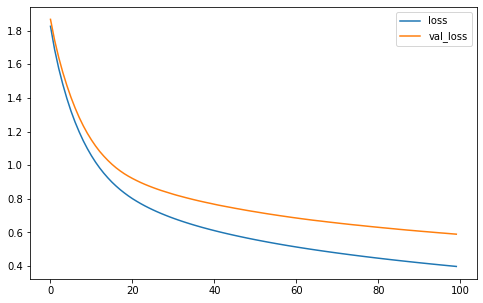

In [43]:
liquid_history = liquid_ae.fit(df_liquid, df_liquid,
                         epochs=100, batch_size=100, validation_split=0.2)

liquid_ae.evaluate(df_liquid, df_liquid)

plt.figure(figsize=(8,5))
plt.plot(liquid_history.history['loss'], label='loss')
plt.plot(liquid_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [44]:
X_liquid_vector = liquid_ae.encoder.predict(df_liquid)

19/19 [==============================] - 0s 2ms/step


### RNA-seq

In [45]:
rna_size = df_rnaseq.shape[1]
rna_hidden_sizes = [1024, 512, 256]
rna_size

28284

In [46]:
rna_ae = get_ae_model(rna_size, rna_hidden_sizes, LATENT_SIZE, 'rna')

In [47]:
rna_ae.compile(loss="mse", optimizer=optimizer)
rna_ae.summary()

Model: "rna_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rna_input (InputLayer)      [(None, 28284)]           0         
                                                                 
 rna_encoder (Functional)    (None, 128)               29652864  
                                                                 
 rna_decoder (Functional)    (None, 28284)             29681020  
                                                                 
Total params: 59,333,884
Trainable params: 59,333,884
Non-trainable params: 0
_________________________________________________________________


Epoch 1/300
5/5 [==============================] - 2s 182ms/step - loss: 4.6927 - val_loss: 1.5578
Epoch 2/300
5/5 [==============================] - 0s 89ms/step - loss: 0.8728 - val_loss: 0.4339
Epoch 3/300
5/5 [==============================] - 0s 90ms/step - loss: 0.3654 - val_loss: 0.2715
Epoch 4/300
5/5 [==============================] - 0s 88ms/step - loss: 0.1998 - val_loss: 0.1429
Epoch 5/300
5/5 [==============================] - 0s 90ms/step - loss: 0.1240 - val_loss: 0.0996
Epoch 6/300
5/5 [==============================] - 0s 91ms/step - loss: 0.0933 - val_loss: 0.0818
Epoch 7/300
5/5 [==============================] - 0s 89ms/step - loss: 0.0767 - val_loss: 0.0703
Epoch 8/300
5/5 [==============================] - 0s 86ms/step - loss: 0.0681 - val_loss: 0.0635
Epoch 9/300
5/5 [==============================] - 0s 87ms/step - loss: 0.0628 - val_loss: 0.0601
Epoch 10/300
5/5 [==============================] - 0s 87ms/step - loss: 0.0597 - val_loss: 0.0577
Epoch 11/300
5/5 [

Epoch 165/300
5/5 [==============================] - 0s 84ms/step - loss: 0.0484 - val_loss: 0.0482
Epoch 166/300
5/5 [==============================] - 0s 96ms/step - loss: 0.0483 - val_loss: 0.0481
Epoch 167/300
5/5 [==============================] - 0s 97ms/step - loss: 0.0484 - val_loss: 0.0481
Epoch 168/300
5/5 [==============================] - 0s 98ms/step - loss: 0.0484 - val_loss: 0.0483
Epoch 169/300
5/5 [==============================] - 0s 89ms/step - loss: 0.0485 - val_loss: 0.0483
Epoch 170/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0485 - val_loss: 0.0482
Epoch 171/300
5/5 [==============================] - 0s 95ms/step - loss: 0.0483 - val_loss: 0.0480
Epoch 172/300
5/5 [==============================] - 0s 100ms/step - loss: 0.0482 - val_loss: 0.0482
Epoch 173/300
5/5 [==============================] - 1s 106ms/step - loss: 0.0482 - val_loss: 0.0479
Epoch 174/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0480 - val_loss: 0.0

Epoch 247/300
5/5 [==============================] - 0s 99ms/step - loss: 0.0408 - val_loss: 0.0422
Epoch 248/300
5/5 [==============================] - 0s 85ms/step - loss: 0.0406 - val_loss: 0.0422
Epoch 249/300
5/5 [==============================] - 0s 94ms/step - loss: 0.0406 - val_loss: 0.0424
Epoch 250/300
5/5 [==============================] - 0s 86ms/step - loss: 0.0410 - val_loss: 0.0424
Epoch 251/300
5/5 [==============================] - 0s 87ms/step - loss: 0.0406 - val_loss: 0.0431
Epoch 252/300
5/5 [==============================] - 0s 92ms/step - loss: 0.0413 - val_loss: 0.0416
Epoch 253/300
5/5 [==============================] - 0s 88ms/step - loss: 0.0403 - val_loss: 0.0417
Epoch 254/300
5/5 [==============================] - 0s 83ms/step - loss: 0.0401 - val_loss: 0.0424
Epoch 255/300
5/5 [==============================] - 0s 87ms/step - loss: 0.0403 - val_loss: 0.0422
Epoch 256/300
5/5 [==============================] - 0s 85ms/step - loss: 0.0400 - val_loss: 0.0414


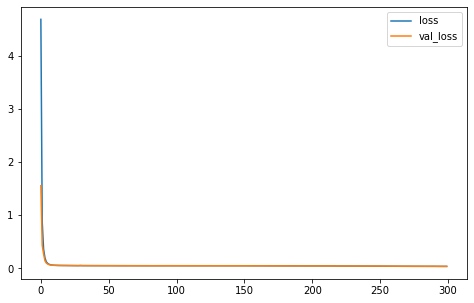

In [48]:
rna_history = rna_ae.fit(df_rnaseq, df_rnaseq,
                         epochs=300, batch_size=100, validation_split=0.2)

rna_ae.evaluate(df_rnaseq, df_rnaseq)

plt.figure(figsize=(8,5))
plt.plot(rna_history.history['loss'], label='loss')
plt.plot(rna_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [49]:
X_rna_vector = rna_ae.encoder.predict(df_rnaseq)

19/19 [==============================] - 0s 6ms/step


### Methyl-seq

In [50]:
meth_size = df_meth.shape[1]
meth_hidden_sizes = [1024, 512, 256]
meth_size

45578

In [51]:
meth_ae = get_ae_model(meth_size, meth_hidden_sizes, LATENT_SIZE, 'meth')

In [52]:
meth_ae.compile(loss="mse", optimizer=optimizer)
meth_ae.summary()

Model: "meth_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 meth_input (InputLayer)     [(None, 45578)]           0         
                                                                 
 meth_encoder (Functional)   (None, 128)               47361920  
                                                                 
 meth_decoder (Functional)   (None, 45578)             47407370  
                                                                 
Total params: 94,769,290
Trainable params: 94,769,290
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
5/5 [==============================] - 2s 251ms/step - loss: 0.4566 - val_loss: 0.1403
Epoch 2/100
5/5 [==============================] - 1s 142ms/step - loss: 0.1171 - val_loss: 0.0419
Epoch 3/100
5/5 [==============================] - 1s 136ms/step - loss: 0.0584 - val_loss: 0.0343
Epoch 4/100
5/5 [==============================] - 1s 140ms/step - loss: 0.0296 - val_loss: 0.0185
Epoch 5/100
5/5 [==============================] - 1s 208ms/step - loss: 0.0170 - val_loss: 0.0283
Epoch 6/100
5/5 [==============================] - 1s 182ms/step - loss: 0.0245 - val_loss: 0.0117
Epoch 7/100
5/5 [==============================] - 1s 170ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 8/100
5/5 [==============================] - 1s 154ms/step - loss: 0.0076 - val_loss: 0.0058
Epoch 9/100
5/5 [==============================] - 1s 161ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 10/100
5/5 [==============================] - 1s 143ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 11/

5/5 [==============================] - 1s 187ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 84/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 85/100
5/5 [==============================] - 1s 155ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 86/100
5/5 [==============================] - 1s 158ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 87/100
5/5 [==============================] - 1s 158ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 88/100
5/5 [==============================] - 1s 151ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 89/100
5/5 [==============================] - 1s 145ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 90/100
5/5 [==============================] - 1s 148ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 91/100
5/5 [==============================] - 1s 149ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 92/100
5/5 [==============================] - 1s 138ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 93/100


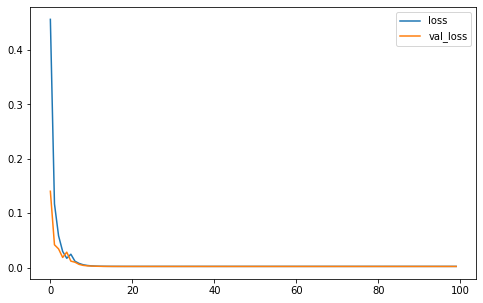

In [53]:
meth_history = meth_ae.fit(df_meth, df_meth,
                         epochs=100, batch_size=100, validation_split=0.2)

meth_ae.evaluate(df_meth, df_meth)

plt.figure(figsize=(8,5))
plt.plot(meth_history.history['loss'], label='loss')
plt.plot(meth_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [54]:
X_meth_vector = meth_ae.encoder.predict(df_meth)

19/19 [==============================] - 0s 8ms/step


### 차원축소 결과 확인

In [55]:
X_liquid_vector.shape, X_meth_vector.shape, X_rna_vector.shape

((600, 128), (600, 128), (600, 128))

In [56]:
np.squeeze(df_target).shape, np.squeeze(df_target).shape

((600,), (600,))

## 분류 모델 학습 및 평가

### 모델 학습

#### 데이터 분할

In [57]:
labels = pd.get_dummies(df_target, prefix='', prefix_sep='').columns
y_array = pd.get_dummies(df_target, prefix='', prefix_sep='').values
y_array.shape

(600, 3)

In [58]:
index_array = np.array([i for i in range(y_array.shape[0])])
index_array

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [59]:
from sklearn.model_selection import train_test_split

index_train, index_test, y_train, y_test = train_test_split(
    index_array, y_array)
y_train.shape, y_test.shape, index_train, index_test

((450, 3),
 (150, 3),
 array([159,  32, 412, 393, 526, 478, 197, 456, 579, 588,  98, 253,  87,
        387, 128, 530, 378, 385, 240,  47, 210, 525, 373, 204, 400, 150,
         73, 188, 558, 551, 444, 577,  91, 468, 543, 544, 317, 572, 325,
         43,  99,  26, 430, 574, 557, 166, 101,  61,  11, 581, 503, 545,
        168, 438, 124, 207, 420, 179, 157,  63, 316,  18, 192, 211, 181,
         54, 286, 151, 213,   3, 380, 310, 437, 517,  65, 129, 219, 118,
        445, 549,  84,  56, 282,  76,  41, 472, 315,  33, 107, 441, 255,
        112, 218, 392, 289, 521, 307, 470,  75, 589, 275, 148,  38,  83,
        484, 465, 406, 524, 375,  51,  40, 200, 590, 576, 293, 515, 541,
        592, 354,  34,  29, 208, 479, 464, 353, 280, 334, 142, 425, 153,
         78, 137, 424, 193, 582, 383, 352,  90, 435, 489, 269, 158, 212,
        423, 471, 361, 459, 119, 537, 586, 358, 410,  71, 305, 170, 403,
        550, 398,  27, 520, 532, 202, 336, 174, 245, 133, 427, 414, 568,
         70, 270, 283, 242, 2

In [60]:
X_train_liquid_vector, X_test_liquid_vector = X_liquid_vector[index_train], X_liquid_vector[index_test]
X_train_rna_vector, X_test_rna_vector = X_rna_vector[index_train], X_rna_vector[index_test]
X_train_meth_vector, X_test_meth_vector = X_meth_vector[index_train], X_meth_vector[index_test]

X_train_liquid_vector.shape, X_test_liquid_vector.shape, \
X_train_rna_vector.shape, X_test_rna_vector.shape, \
X_train_meth_vector.shape, X_test_meth_vector.shape

((450, 128), (150, 128), (450, 128), (150, 128), (450, 128), (150, 128))

#### 모델 학습

In [61]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 50
EPOCHS = 300

In [62]:
def build_dnn_clsf(LATENT_SIZE, last_node, activation_f):
    liquid_input = tf.keras.layers.Input(
        shape=LATENT_SIZE, name='liquid', dtype='float64')
    meth_input = tf.keras.layers.Input(
        shape=LATENT_SIZE, name='meth', dtype='float64')
    rna_input = tf.keras.layers.Input(
        shape=LATENT_SIZE, name='rna', dtype='float64')

    mmm = tf.keras.layers.concatenate([liquid_input, meth_input, rna_input])
    mmm = tf.keras.layers.Dense(128)(mmm)
    mmm = tf.keras.layers.Dense(32, activation='relu')(mmm)
    mmm = tf.keras.layers.Dense(last_node, activation=activation_f)(mmm)

    model = tf.keras.models.Model(
        inputs=[liquid_input, meth_input, rna_input], outputs=mmm)

    return model

def train_clf_for_mmm(X_train, y_train, X_test, y_test, labels,
            latent_size, epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE):
    if len(labels) == 2:
        last_node = 1
        loss_f = 'binary_crossentropy'
        activation_f = 'sigmoid'
    else:
        last_node = len(labels)
        loss_f = 'categorical_crossentropy'
        activation_f = 'softmax'

    # get multimodal model
    model = build_dnn_clsf(latent_size, last_node, activation_f)
    print(model.summary)

    auc = tf.keras.metrics.AUC()
    metrics = ['accuracy', auc]

    # define optimizer
    adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # compile
    model.compile(optimizer=adam, loss=loss_f, metrics=metrics)

    print(model.summary())

    # model training
    history = model.fit(
        X_train, y_train,
        epochs=epochs, validation_data=(X_test, y_test),
    batch_size=batch_size, verbose=2)

    return model, history

In [63]:
y_train.shape, y_test.shape, labels

((450, 3), (150, 3), Index(['BBB', 'GGG', 'RRR'], dtype='object'))

In [64]:
_ = train_clf_for_mmm({
    'liquid': X_train_liquid_vector, 
    'meth': X_train_meth_vector, 
    'rna': X_train_rna_vector}, 
    np.squeeze(y_train), {
        'liquid': X_test_liquid_vector, 
        'meth': X_test_meth_vector, 
        'rna': X_test_rna_vector
    }, np.squeeze(y_test), 
    labels=labels, latent_size=LATENT_SIZE, 
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE
)

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f0196315e80>>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 liquid (InputLayer)            [(None, 128)]        0           []                               
                                                                                                  
 meth (InputLayer)              [(None, 128)]        0           []                               
                                                                                                  
 rna (InputLayer)               [(None, 128)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 384)          0           ['liquid[0][0]',                 


9/9 - 0s - loss: 0.2987 - accuracy: 0.9200 - auc: 0.9817 - val_loss: 0.3896 - val_accuracy: 0.8467 - val_auc: 0.9603 - 114ms/epoch - 13ms/step
Epoch 40/300
9/9 - 0s - loss: 0.2954 - accuracy: 0.9133 - auc: 0.9822 - val_loss: 0.3886 - val_accuracy: 0.8467 - val_auc: 0.9593 - 119ms/epoch - 13ms/step
Epoch 41/300
9/9 - 0s - loss: 0.2988 - accuracy: 0.9111 - auc: 0.9803 - val_loss: 0.3878 - val_accuracy: 0.8400 - val_auc: 0.9592 - 107ms/epoch - 12ms/step
Epoch 42/300
9/9 - 0s - loss: 0.2961 - accuracy: 0.9133 - auc: 0.9818 - val_loss: 0.3755 - val_accuracy: 0.8600 - val_auc: 0.9618 - 108ms/epoch - 12ms/step
Epoch 43/300
9/9 - 0s - loss: 0.2797 - accuracy: 0.9267 - auc: 0.9847 - val_loss: 0.3733 - val_accuracy: 0.8533 - val_auc: 0.9625 - 114ms/epoch - 13ms/step
Epoch 44/300
9/9 - 0s - loss: 0.2784 - accuracy: 0.9267 - auc: 0.9850 - val_loss: 0.3772 - val_accuracy: 0.8467 - val_auc: 0.9610 - 107ms/epoch - 12ms/step
Epoch 45/300
9/9 - 0s - loss: 0.2768 - accuracy: 0.9000 - auc: 0.9845 - val_l

Epoch 92/300
9/9 - 0s - loss: 0.1841 - accuracy: 0.9444 - auc: 0.9927 - val_loss: 0.3186 - val_accuracy: 0.8800 - val_auc: 0.9704 - 113ms/epoch - 13ms/step
Epoch 93/300
9/9 - 0s - loss: 0.1759 - accuracy: 0.9511 - auc: 0.9934 - val_loss: 0.2995 - val_accuracy: 0.8733 - val_auc: 0.9741 - 113ms/epoch - 13ms/step
Epoch 94/300
9/9 - 0s - loss: 0.1689 - accuracy: 0.9511 - auc: 0.9947 - val_loss: 0.3066 - val_accuracy: 0.8667 - val_auc: 0.9729 - 120ms/epoch - 13ms/step
Epoch 95/300
9/9 - 0s - loss: 0.1848 - accuracy: 0.9333 - auc: 0.9919 - val_loss: 0.2972 - val_accuracy: 0.8800 - val_auc: 0.9745 - 116ms/epoch - 13ms/step
Epoch 96/300
9/9 - 0s - loss: 0.1659 - accuracy: 0.9600 - auc: 0.9951 - val_loss: 0.3024 - val_accuracy: 0.8667 - val_auc: 0.9740 - 114ms/epoch - 13ms/step
Epoch 97/300
9/9 - 0s - loss: 0.1643 - accuracy: 0.9600 - auc: 0.9952 - val_loss: 0.2955 - val_accuracy: 0.8800 - val_auc: 0.9747 - 115ms/epoch - 13ms/step
Epoch 98/300
9/9 - 0s - loss: 0.1652 - accuracy: 0.9511 - auc: 0

Epoch 145/300
9/9 - 0s - loss: 0.1231 - accuracy: 0.9644 - auc: 0.9973 - val_loss: 0.2970 - val_accuracy: 0.8933 - val_auc: 0.9748 - 116ms/epoch - 13ms/step
Epoch 146/300
9/9 - 0s - loss: 0.1277 - accuracy: 0.9622 - auc: 0.9969 - val_loss: 0.2847 - val_accuracy: 0.8800 - val_auc: 0.9765 - 114ms/epoch - 13ms/step
Epoch 147/300
9/9 - 0s - loss: 0.1271 - accuracy: 0.9667 - auc: 0.9975 - val_loss: 0.3059 - val_accuracy: 0.8933 - val_auc: 0.9722 - 115ms/epoch - 13ms/step
Epoch 148/300
9/9 - 0s - loss: 0.1372 - accuracy: 0.9556 - auc: 0.9958 - val_loss: 0.2957 - val_accuracy: 0.8933 - val_auc: 0.9751 - 113ms/epoch - 13ms/step
Epoch 149/300
9/9 - 0s - loss: 0.1215 - accuracy: 0.9689 - auc: 0.9974 - val_loss: 0.2853 - val_accuracy: 0.8733 - val_auc: 0.9769 - 111ms/epoch - 12ms/step
Epoch 150/300
9/9 - 0s - loss: 0.1210 - accuracy: 0.9689 - auc: 0.9973 - val_loss: 0.2905 - val_accuracy: 0.9000 - val_auc: 0.9754 - 109ms/epoch - 12ms/step
Epoch 151/300
9/9 - 0s - loss: 0.1226 - accuracy: 0.9667 -

Epoch 198/300
9/9 - 0s - loss: 0.1002 - accuracy: 0.9689 - auc: 0.9982 - val_loss: 0.3061 - val_accuracy: 0.8867 - val_auc: 0.9739 - 110ms/epoch - 12ms/step
Epoch 199/300
9/9 - 0s - loss: 0.0951 - accuracy: 0.9756 - auc: 0.9984 - val_loss: 0.3011 - val_accuracy: 0.8867 - val_auc: 0.9740 - 119ms/epoch - 13ms/step
Epoch 200/300
9/9 - 0s - loss: 0.0924 - accuracy: 0.9800 - auc: 0.9986 - val_loss: 0.2889 - val_accuracy: 0.8800 - val_auc: 0.9771 - 109ms/epoch - 12ms/step
Epoch 201/300
9/9 - 0s - loss: 0.0969 - accuracy: 0.9733 - auc: 0.9984 - val_loss: 0.2854 - val_accuracy: 0.8800 - val_auc: 0.9780 - 112ms/epoch - 12ms/step
Epoch 202/300
9/9 - 0s - loss: 0.0966 - accuracy: 0.9733 - auc: 0.9983 - val_loss: 0.3121 - val_accuracy: 0.8867 - val_auc: 0.9704 - 111ms/epoch - 12ms/step
Epoch 203/300
9/9 - 0s - loss: 0.0951 - accuracy: 0.9733 - auc: 0.9983 - val_loss: 0.3002 - val_accuracy: 0.8867 - val_auc: 0.9742 - 110ms/epoch - 12ms/step
Epoch 204/300
9/9 - 0s - loss: 0.0925 - accuracy: 0.9822 -

Epoch 251/300
9/9 - 0s - loss: 0.0765 - accuracy: 0.9844 - auc: 0.9992 - val_loss: 0.3697 - val_accuracy: 0.8667 - val_auc: 0.9678 - 118ms/epoch - 13ms/step
Epoch 252/300
9/9 - 0s - loss: 0.0947 - accuracy: 0.9644 - auc: 0.9982 - val_loss: 0.3044 - val_accuracy: 0.8733 - val_auc: 0.9754 - 115ms/epoch - 13ms/step
Epoch 253/300
9/9 - 0s - loss: 0.0772 - accuracy: 0.9800 - auc: 0.9992 - val_loss: 0.3014 - val_accuracy: 0.8800 - val_auc: 0.9753 - 120ms/epoch - 13ms/step
Epoch 254/300
9/9 - 0s - loss: 0.0803 - accuracy: 0.9844 - auc: 0.9988 - val_loss: 0.3074 - val_accuracy: 0.8733 - val_auc: 0.9719 - 134ms/epoch - 15ms/step
Epoch 255/300
9/9 - 0s - loss: 0.0892 - accuracy: 0.9733 - auc: 0.9984 - val_loss: 0.3125 - val_accuracy: 0.8867 - val_auc: 0.9717 - 114ms/epoch - 13ms/step
Epoch 256/300
9/9 - 0s - loss: 0.0766 - accuracy: 0.9844 - auc: 0.9992 - val_loss: 0.3200 - val_accuracy: 0.8867 - val_auc: 0.9716 - 122ms/epoch - 14ms/step
Epoch 257/300
9/9 - 0s - loss: 0.0855 - accuracy: 0.9756 -

In [65]:
model, history = _

학습 곡선

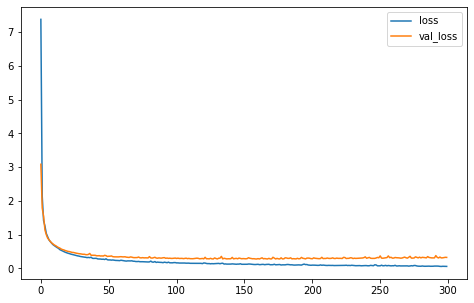

In [66]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

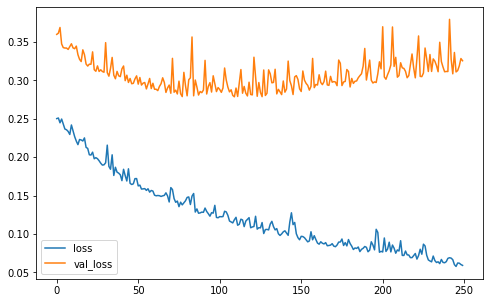

In [67]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][50:], label='loss')
plt.plot(history.history['val_loss'][50:], label='val_loss')
plt.legend()
plt.show()

**학습 곡선(learning curve)의 해석**

학습 곡선(learning curve)은 인공신경망의 학습 에폭(Epochs)마다 손실(loss)를 계산하여 시각화한 자료로, 모델의 학습이 원활하게 이루어지고 있는지 확인하기 위한 목적으로 사용됩니다. 일반적으로 좋은 모델은 training loss와 validation loss가 작은 값으로 수렴하는 양상을 나타내는데, 그렇지 않은 경우 underfitting, overfitting 인지 확인할 수 있습니다. loss가 수렴하지 않고 계속해서 모델이 saturation되기 전 단계로 underfitting이며, 학습 곡선에서 validation loss가 하락하다가, 특정 시점 이후부터 상승한다면 모델이 학습 데이터 세트에 과적합(overfitting)되었다고 판단할 수 있습니다. 만약 underfitting된 경우 epoch을 늘려 학습을 진행하고 과적합된 경우에는 val_loss가 상승하기 전에 학습을 중단합니다. 과적합이 진행되지 않도록 loss 를 모니터링하다가 학습을 중단하는 EarlyStopping 기능을 활용할 수도 있습니다.

### 모델 평가

In [68]:
model.evaluate({
    'liquid': X_test_liquid_vector, 
    'meth': X_test_meth_vector, 
    'rna': X_test_rna_vector}, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.3254 - accuracy: 0.8867 - auc: 0.9721


[0.3254421353340149, 0.8866666555404663, 0.972111165523529]

In [69]:
model.evaluate({'liquid': X_train_liquid_vector, 'meth': X_train_meth_vector, 'rna': X_train_rna_vector}, y_train)

15/15 [==============================] - 0s 5ms/step - loss: 0.0568 - accuracy: 0.9889 - auc: 0.9998


[0.056751180440187454, 0.9888888597488403, 0.9997727870941162]